# Decoding Shor's Code

In this experiment, we decode Shor's nine-qubit quantum error correcting code which protects a single qubit from all types of errors by using ``mdopt``. Here, we demonstrate direct-error input decoding, which means that the decoder takes a Pauli error as input and outputs the most likely logical operator. This pipeline is sufficient for threshold computation. In reality, the decoder could be shown a syndrome measurement, from which possible error patterns would be sampled. After each run, the algorithm yields a probability distribution over the Pauli operators (I, X, Z, Y) to apply to the encoded logical qubit. Hereafter, we assume an independent noise model as well as perfect syndrome measurements. In this experiment, we do not truncate the tensor network thus perform exact maximum likelihood decoding.

In [1]:
import numpy as np
import qecstruct as qc
import qecsim.paulitools as pt
import matplotlib.pyplot as plt
from tqdm import tqdm

from mdopt.mps.utils import marginalise, create_custom_product_state
from mdopt.contractor.contractor import mps_mpo_contract
from mdopt.optimiser.utils import (
    SWAP,
    COPY_LEFT,
    XOR_BULK,
    XOR_LEFT,
    XOR_RIGHT,
)
from examples.decoding.decoding import (
    css_code_checks,
    css_code_logicals,
    css_code_logicals_sites,
    css_code_constraint_sites,
)
from examples.decoding.decoding import (
    apply_constraints,
    apply_bitflip_bias,
)
from examples.decoding.decoding import (
    pauli_to_mps,
    decode_css,
)

Let us first import the code from `qecstruct` and take a look at it.

In [2]:
code = qc.shor_code()
print(code)
print("The X logical: ", code.x_logicals_binary())
print("The Z logical: ", code.z_logicals_binary())

X stabilizers:
[0, 1, 2, 3, 4, 5]
[3, 4, 5, 6, 7, 8]
Z stabilizers:
[0, 1]
[1, 2]
[3, 4]
[4, 5]
[6, 7]
[7, 8]

The X logical:  [0, 1, 2]

The Z logical:  [0, 3, 6]



This quantum error correcting code is defined on $9$ physical qubits and has $2$ logical operators because it encodes $1$ logical qubit. This means we will need $9*2 + 2 = 20$ sites in our MPS.

In [3]:
num_logicals = code.num_x_logicals() + code.num_z_logicals()
num_sites = 2 * len(code) + num_logicals

assert num_sites == 20
assert num_logicals == 2

Now, let us define the initial state. First of all we will check that no error implies no correction. This means starting from the all-zero state followed by decoding will return all-zero state for the logical operators (the final logical operator will thus be identity operator). Thus, we start from the all-zero state for the error and the $|+\rangle$ state for the logicals.

In [4]:
error_state = "0" * (num_sites - num_logicals)
logicals_state = "+" * num_logicals
state_string = logicals_state + error_state
error_mps = create_custom_product_state(string=state_string)

Here, we get the sites where the checks will be applied. We will need to construct MPOs using this data.

In [5]:
checks_x, checks_z = css_code_checks(code)
print("X checks:")
for check in checks_x:
    print(check)
print("Z checks:")
for check in checks_z:
    print(check)

X checks:
[2, 4, 6, 8, 10, 12]
[8, 10, 12, 14, 16, 18]
Z checks:
[3, 5]
[5, 7]
[9, 11]
[11, 13]
[15, 17]
[17, 19]


These lists mention only the sites where we will apply the XOR constraints. However, the MPOs will also consist of other tensors, such as SWAPs (tensors' legs crossings) and boundary XOR constraints. In what follows we define the list of these auxiliary tensors and the corresponding sites where they reside.

In [6]:
constraints_tensors = [XOR_LEFT, XOR_BULK, SWAP, XOR_RIGHT]
logicals_tensors = [COPY_LEFT, XOR_BULK, SWAP, XOR_RIGHT]

In [7]:
constraint_sites = css_code_constraint_sites(code)
print("Full X-check lists of sites:")
for string in constraint_sites[0]:
    print(string)
print("Full Z-check lists of sites:")
for string in constraint_sites[1]:
    print(string)

Full X-check lists of sites:
[[2], [4, 6, 8, 10], [3, 5, 7, 9, 11], [12]]
[[8], [10, 12, 14, 16], [9, 11, 13, 15, 17], [18]]
Full Z-check lists of sites:
[[3], [], [4], [5]]
[[5], [], [6], [7]]
[[9], [], [10], [11]]
[[11], [], [12], [13]]
[[15], [], [16], [17]]
[[17], [], [18], [19]]


Let us now again take a look at the logical operators.

In [8]:
print(code.x_logicals_binary())
print(code.z_logicals_binary())

[0, 1, 2]

[0, 3, 6]



We need to again translate them to our MPO language by changing the indices since we add the logical sites at the beginning of the MPS.

In [9]:
print(css_code_logicals(code)[0])
print(css_code_logicals(code)[1])

[[2, 4, 6]]
[[3, 9, 15]]


Now goes the same operation of adding sites where auxiliary tensors should be placed.

In [10]:
logicals_sites = css_code_logicals_sites(code)
print(css_code_logicals_sites(code)[0])
print(css_code_logicals_sites(code)[1])

[[[0], [2, 4], [1, 3, 5], [6]]]
[[[1], [3, 9], [2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14], [15]]]


Now the fun part, MPS-MPO contraction. But first, we apply the bias channel to our error state. This is done to bias our output towards the received input. This is done by distributing the amplitude around the initial basis product state to other basis product states in the descending order by Hamming distance.

Finally, the tensor network we are going to build is going to look as follows:
<img src="shor-decoder.png" alt="Tensor-network error-based decoder for the Shor's 9-qubit code." />

In [11]:
renormalise = True
result_to_explicit = False
sites_to_bias = list(range(num_logicals, num_sites))
error_mps = apply_bitflip_bias(
    mps=error_mps,
    sites_to_bias=sites_to_bias,
    renormalise=renormalise,
)

In [12]:
for i in [0, 1]:
    error_mps = apply_constraints(
        error_mps,
        constraint_sites[i],
        constraints_tensors,
        renormalise=renormalise,
        result_to_explicit=result_to_explicit,
        strategy="Optimised",
    )
for i in [0, 1]:
    error_mps = apply_constraints(
        error_mps,
        logicals_sites[i],
        logicals_tensors,
        renormalise=renormalise,
        result_to_explicit=result_to_explicit,
        strategy="Optimised",
    )

100%|██████████| 1/1 [00:00<00:00, 123.62it/s]


Now, we marginalise over the message bits to get the probability distribution over the four possibilities of a logical operator: $I$, $X$, $Z$, $Y$.

In [13]:
sites_to_marginalise = list(range(num_logicals, len(error_state) + num_logicals))
logical = marginalise(mps=error_mps, sites_to_marginalise=sites_to_marginalise).dense(
    flatten=True, renormalise=True, norm=1
)
print(logical)

[0.61225663 0.06778069 0.28807136 0.03189132]


Which indeed tells us that most likely we do not need to apply any operator!

Let's now put all of this into a function. We'll need this to run the decoder over a bunch of single- and multiqubit errors.

Let's now generate all possible one-, two- and three-qubit errors using `qecsim`.

In [14]:
one_qubit_paulis = pt.ipauli(n_qubits=len(code), min_weight=1, max_weight=1)
two_qubit_paulis = pt.ipauli(n_qubits=len(code), min_weight=2, max_weight=2)
three_qubit_paulis = pt.ipauli(n_qubits=len(code), min_weight=3, max_weight=3)

In [15]:
one_qubit_outputs = [
    decode_css(
        code,
        error,
        bias_type="Bitflip",
        renormalise=renormalise,
        silent=True,
        bias_prob=0,
    )
    for error in tqdm(one_qubit_paulis)
]
one_qubit_corrections_distribution = [output[0] for output in one_qubit_outputs]

0it [00:00, ?it/s]/Users/aleksandrberezutskii/mdopt/mdopt/mps/canonical.py:274: RuntimeWarning: invalid value encountered in divide
  dense /= np.linalg.norm(dense, ord=norm)
27it [00:00, 57.28it/s]


In [16]:
two_qubit_outputs = [
    decode_css(code, error, bias_type="Bitflip", renormalise=renormalise, silent=True)
    for error in tqdm(two_qubit_paulis)
]
two_qubit_corrections_distribution = [output[0] for output in two_qubit_outputs]

324it [00:04, 71.60it/s]


In [17]:
three_qubit_outputs = [
    decode_css(code, error, bias_type="Bitflip", renormalise=renormalise, silent=True)
    for error in tqdm(three_qubit_paulis)
]
three_qubit_corrections_distribution = [output[0] for output in three_qubit_outputs]

2268it [00:32, 68.75it/s]


In [18]:
def map_distribution_to_pauli(distribution):
    mapping = {0: "I", 1: "X", 2: "Z", 3: "Y"}
    result = []

    for array in distribution:
        max_index = np.argmax(array)
        result.append(mapping[max_index])

    return result

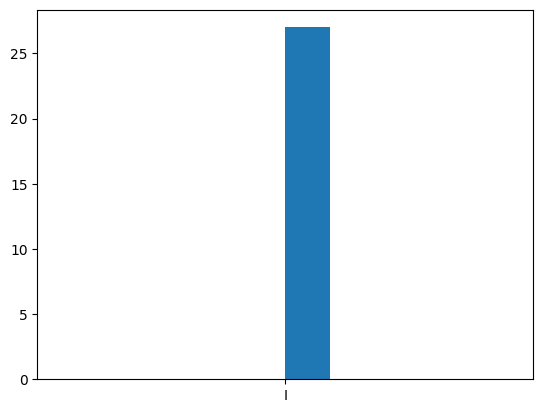

In [19]:
plt.hist(map_distribution_to_pauli(one_qubit_corrections_distribution))
plt.show()

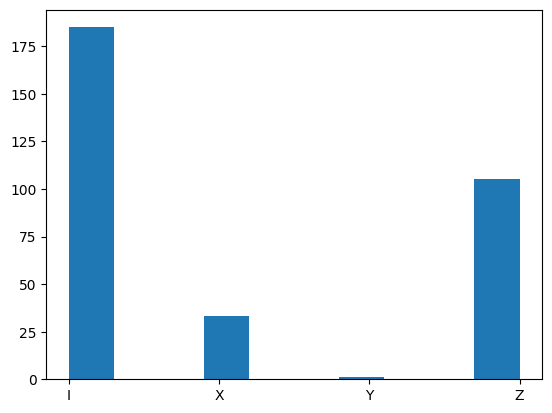

In [20]:
plt.hist(map_distribution_to_pauli(two_qubit_corrections_distribution))
plt.show()

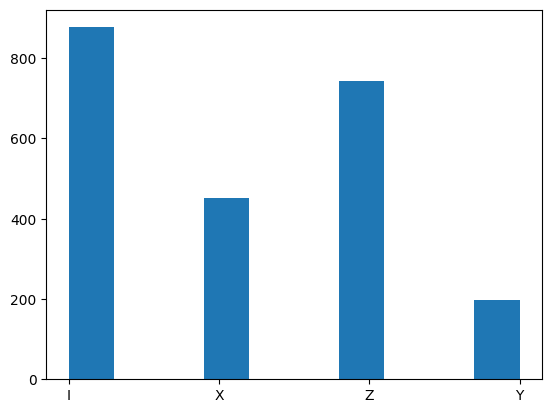

In [21]:
plt.hist(map_distribution_to_pauli(three_qubit_corrections_distribution))
plt.show()

Let's now check by hand that some of the decoder's nontrivial outputs are indeed correct. First of all, from all one-qubit errors we get the Identity operator which corresponds to the fact that Shor's code corrects all one-qubit errors. However, Shor's code can also correct some two-qubit errors.

In [22]:
one_qubit_paulis = list(pt.ipauli(n_qubits=len(code), min_weight=1, max_weight=1))
two_qubit_paulis = list(pt.ipauli(n_qubits=len(code), min_weight=2, max_weight=2))
three_qubit_paulis = list(pt.ipauli(n_qubits=len(code), min_weight=3, max_weight=3))

Let's take a look at the first 20 errors which result in the Identity logical operator as the output.

In [23]:
limit = 20
for i, correction in enumerate(
    map_distribution_to_pauli(two_qubit_corrections_distribution)
):
    if correction == "I":
        print(two_qubit_paulis[i])
    if i > limit:
        break

XXIIIIIII
XZIIIIIII
XYIIIIIII
ZXIIIIIII
YXIIIIIII
XIXIIIIII
XIZIIIIII
XIYIIIIII
ZIXIIIIII
XIIZIIIII
ZIIXIIIII


We now want to dive a bit more into what is happening inside the decoder to be able to better understand the results, even though the current setup is already sufficient for calculating thresholds. For example, the first error $(X_0 X_1)$ from the list above would trigger the first $X$ parity check in the case of measuring it. This can be seen from the actual tensor network we are building (see the image below). However, in the current setup the stabilisers are being set to $0$, which is the result of the fact that the $\text{XOR}$ tensors we use project out the inputs of odd (i.e., equal to $1$) parity. After applying the logical-operator MPOs and performing marginalization, the process yields a marginal distribution over codewords, each reflecting different parities of the logical operators.

<img src="shor-decoder.png" alt="Tensor-network error-based decoder for the Shor's 9-qubit code."/>

Let's now take a look at the errors which result in the $X$ logical operator as the output.

In [24]:
for i, correction in enumerate(
    map_distribution_to_pauli(two_qubit_corrections_distribution)
):
    if correction == "X":
        print(two_qubit_paulis[i])

ZZIIIIIII
ZYIIIIIII
YZIIIIIII
YYIIIIIII
ZIZIIIIII
ZIYIIIIII
YIXIIIIII
YIZIIIIII
YIIZIIIII
IZZIIIIII
IYZIIIIII
IYYIIIIII
IIIZYIIII
IIIYZIIII
IIIYYIIII
IIIZIZIII
IIIZIYIII
IIIYIZIII
IIIYIYIII
IIIIZZIII
IIIIZYIII
IIIIYZIII
IIIIIIZZI
IIIIIIZYI
IIIIIIYZI
IIIIIIZIZ
IIIIIIZIY
IIIIIIYIZ
IIIIIIYIY
IIIIIIIZZ
IIIIIIIZY
IIIIIIIYZ
IIIIIIIYY


Similarly to the previous case, the first error $(Z_0 Z_1)$ from the list above would trigger the first $Z$ parity check which in its turn would trigger the $\text{XOR}$ tensor corresponding to the $X$ logical-operator MPO therefore the $X$ logical as the most likely output.